In [1]:
# 1. IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import time
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ Libraries imported successfully!
TensorFlow version: 2.19.0



DOWNLOADING DATASET FROM KAGGLE
Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
✅ Dataset downloaded to: /kaggle/input/chest-xray-pneumonia

LOADING TRAINING DATA
Loading NORMAL images...
✅ Loaded 1341 NORMAL images
Loading PNEUMONIA images...
✅ Loaded 3875 PNEUMONIA images

LOADING TEST DATA
Loading NORMAL images...
✅ Loaded 234 NORMAL images
Loading PNEUMONIA images...
✅ Loaded 390 PNEUMONIA images

LOADING VALIDATION DATA
Loading NORMAL images...
✅ Loaded 8 NORMAL images
Loading PNEUMONIA images...
✅ Loaded 8 PNEUMONIA images

✅ Data loading complete!
   Training:   (5216, 150, 150, 3)
   Test:       (624, 150, 150, 3)
   Validation: (16, 150, 150, 3)

CREATING PROPER TRAIN/VAL SPLIT
⚠️  Original validation set has only 16 images - too small!
💡 Creating 85/15 split from training data...

✅ New splits created:
   Training:   4172 images
   Validation: 1044 images
   Test:       624 images (unchanged)

NORMALIZING PIXEL VALUES
✅ Data normalized to range [0.

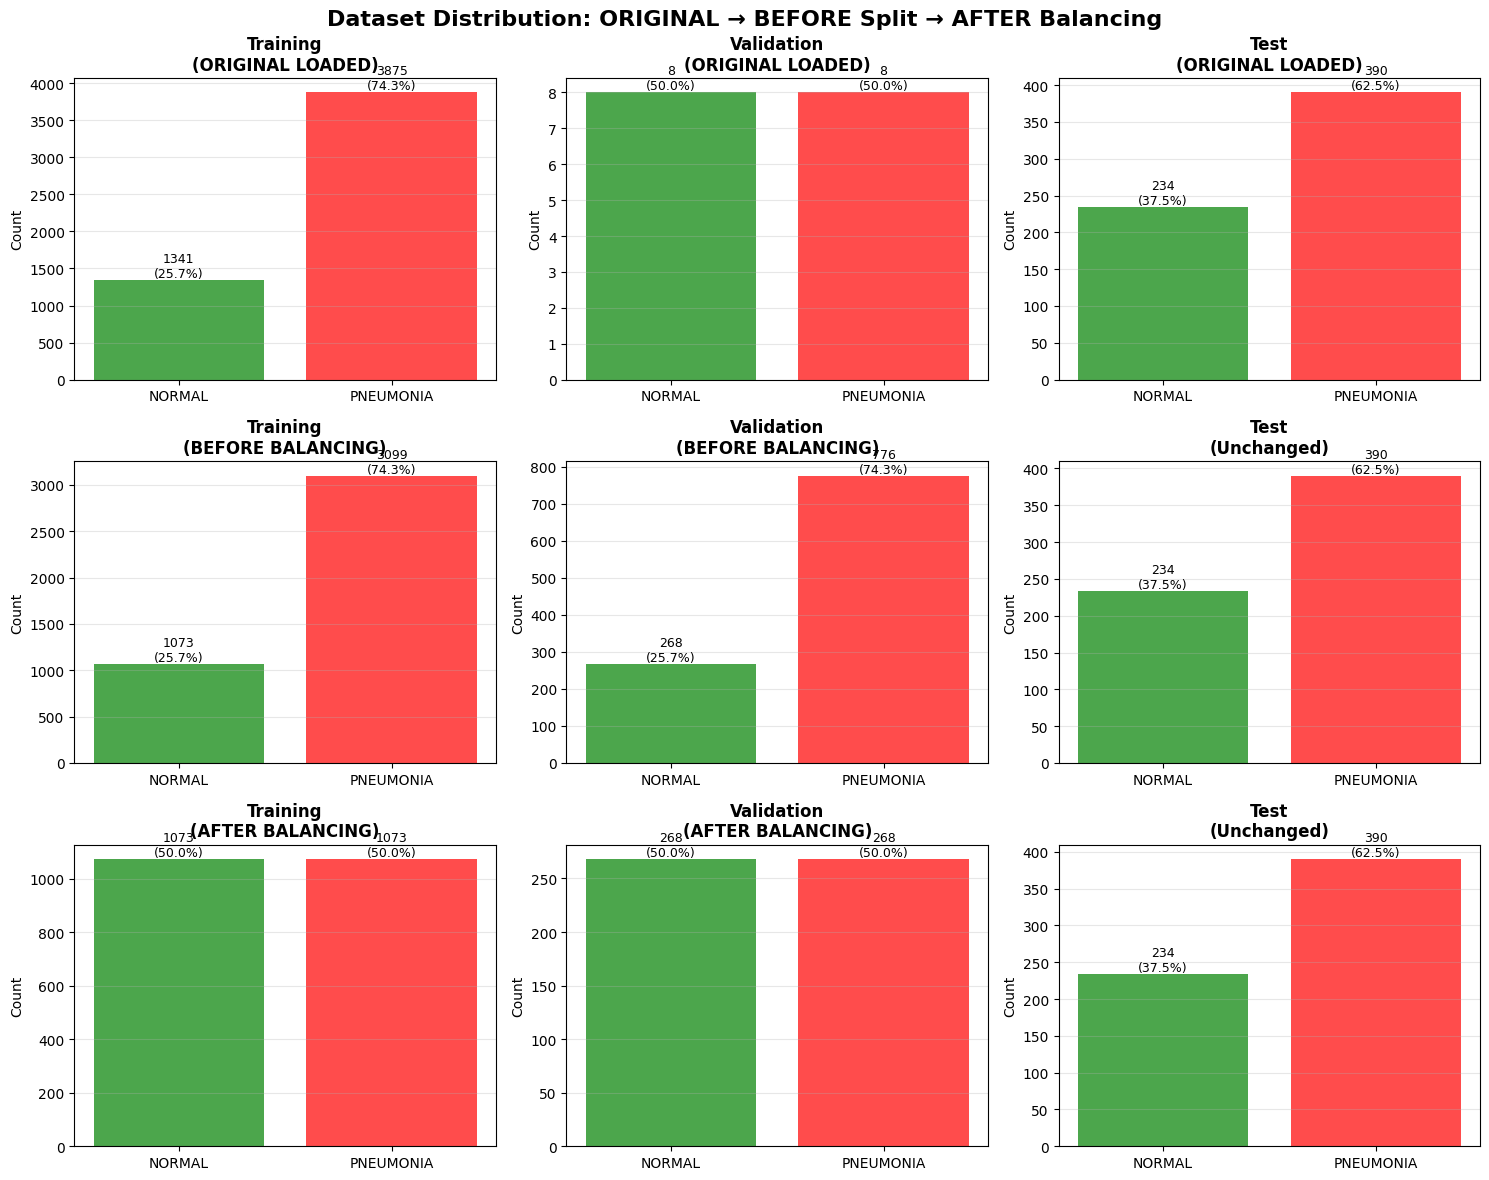

In [2]:

# ============================================
# 2. LOAD DATASET
# ============================================

print("\n" + "="*60)
print("DOWNLOADING DATASET FROM KAGGLE")
print("="*60)

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("✅ Dataset downloaded to:", path)

# Define directories
BASE_DIR = os.path.join(path, 'chest_xray')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

# Image parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150

def load_images_from_directory(directory, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    """Load images from directory with NORMAL and PNEUMONIA subfolders"""
    images = []
    labels = []
    categories = ['NORMAL', 'PNEUMONIA']

    for category_idx, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        if not os.path.exists(category_path):
            print(f"⚠️  Warning: {category_path} does not exist")
            continue

        print(f"Loading {category} images...")
        image_files = os.listdir(category_path)

        for img_file in image_files:
            if img_file.endswith(('.jpeg', '.jpg', '.png')):
                img_path = os.path.join(category_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_width, img_height))
                    images.append(img)
                    labels.append(category_idx)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue

        print(f"✅ Loaded {len([l for l in labels if l == category_idx])} {category} images")

    return np.array(images), np.array(labels)

# Load all data
print("\n" + "="*60)
print("LOADING TRAINING DATA")
print("="*60)
X_train_orig, y_train_orig = load_images_from_directory(TRAIN_DIR)

print("\n" + "="*60)
print("LOADING TEST DATA")
print("="*60)
X_test, y_test = load_images_from_directory(TEST_DIR)

print("\n" + "="*60)
print("LOADING VALIDATION DATA")
print("="*60)
X_val_orig, y_val_orig = load_images_from_directory(VAL_DIR)

print("\n✅ Data loading complete!")
print(f"   Training:   {X_train_orig.shape}")
print(f"   Test:       {X_test.shape}")
print(f"   Validation: {X_val_orig.shape}")

# ============================================
# 3. CREATE PROPER TRAIN/VAL SPLIT
# ============================================

print("\n" + "="*60)
print("CREATING PROPER TRAIN/VAL SPLIT")
print("="*60)

print(f"⚠️  Original validation set has only {len(y_val_orig)} images - too small!")
print(f"💡 Creating 85/15 split from training data...\n")

# Split: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_orig, y_train_orig,
    test_size=0.2,
    random_state=42,
    stratify=y_train_orig
)

print(f"✅ New splits created:")
print(f"   Training:   {X_train.shape[0]} images")
print(f"   Validation: {X_val.shape[0]} images")
print(f"   Test:       {X_test.shape[0]} images (unchanged)")

# ============================================
# 4. NORMALIZE DATA
# ============================================

print("\n" + "="*60)
print("NORMALIZING PIXEL VALUES")
print("="*60)

X_train_scaled = X_train.astype('float32') / 255.0
X_val_scaled = X_val.astype('float32') / 255.0
X_test_scaled = X_test.astype('float32') / 255.0

print(f"✅ Data normalized to range [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")

# ============================================
# 5. SHOW DISTRIBUTION BEFORE BALANCING
# ============================================

print("\n" + "="*60)
print("📊 DATASET DISTRIBUTION (BEFORE BALANCING)")
print("="*60)

print("\nTraining Set:")
print(f"  Total: {len(y_train)} images")
print(f"  NORMAL:    {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  PNEUMONIA: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")

print("\nValidation Set:")
print(f"  Total: {len(y_val)} images")
print(f"  NORMAL:    {np.sum(y_val == 0)} ({np.sum(y_val == 0)/len(y_val)*100:.1f}%)")
print(f"  PNEUMONIA: {np.sum(y_val == 1)} ({np.sum(y_val == 1)/len(y_val)*100:.1f}%)")

print("\nTest Set:")
print(f"  Total: {len(y_test)} images")
print(f"  NORMAL:    {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  PNEUMONIA: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

# ============================================
# 6. BALANCE TRAINING SET (50:50)
# ============================================

print("\n" + "="*60)
print("🔧 BALANCING TRAINING SET (50:50 RATIO)")
print("="*60)

# Get indices
train_normal_idx = np.where(y_train == 0)[0]
train_pneumonia_idx = np.where(y_train == 1)[0]

n_normal_train = len(train_normal_idx)
n_pneumonia_train = len(train_pneumonia_idx)

print(f"Before: Normal={n_normal_train}, Pneumonia={n_pneumonia_train}")

# Downsample pneumonia to match normal
np.random.seed(42)
train_pneumonia_downsampled = np.random.choice(train_pneumonia_idx, n_normal_train, replace=False)

# Combine and shuffle
train_balanced_idx = np.concatenate([train_normal_idx, train_pneumonia_downsampled])
np.random.shuffle(train_balanced_idx)

# Create balanced set
X_train_balanced = X_train_scaled[train_balanced_idx]
y_train_balanced = y_train[train_balanced_idx]

print(f"After:  Normal={np.sum(y_train_balanced == 0)}, Pneumonia={np.sum(y_train_balanced == 1)}")
print(f"✅ Training set balanced: {len(y_train_balanced)} images (50:50)")

# ============================================
# 7. BALANCE VALIDATION SET (50:50)
# ============================================

print("\n" + "="*60)
print("🔧 BALANCING VALIDATION SET (50:50 RATIO)")
print("="*60)

# Get indices
val_normal_idx = np.where(y_val == 0)[0]
val_pneumonia_idx = np.where(y_val == 1)[0]

n_normal_val = len(val_normal_idx)
n_pneumonia_val = len(val_pneumonia_idx)

print(f"Before: Normal={n_normal_val}, Pneumonia={n_pneumonia_val}")

# Downsample pneumonia to match normal
val_pneumonia_downsampled = np.random.choice(val_pneumonia_idx, n_normal_val, replace=False)

# Combine and shuffle
val_balanced_idx = np.concatenate([val_normal_idx, val_pneumonia_downsampled])
np.random.shuffle(val_balanced_idx)

# Create balanced set
X_val_balanced = X_val_scaled[val_balanced_idx]
y_val_balanced = y_val[val_balanced_idx]

print(f"After:  Normal={np.sum(y_val_balanced == 0)}, Pneumonia={np.sum(y_val_balanced == 1)}")
print(f"✅ Validation set balanced: {len(y_val_balanced)} images (50:50)")

# ============================================
# 8. FINAL SUMMARY
# ============================================

print("\n" + "="*60)
print("✅ DATA PREPARATION COMPLETE!")
print("="*60)

print("\n📊 Final Balanced Distribution:")
print("\nTraining Set:")
print(f"  Total: {len(y_train_balanced)} images")
print(f"  NORMAL:    {np.sum(y_train_balanced == 0)} ({np.sum(y_train_balanced == 0)/len(y_train_balanced)*100:.1f}%)")
print(f"  PNEUMONIA: {np.sum(y_train_balanced == 1)} ({np.sum(y_train_balanced == 1)/len(y_train_balanced)*100:.1f}%)")

print("\nValidation Set:")
print(f"  Total: {len(y_val_balanced)} images")
print(f"  NORMAL:    {np.sum(y_val_balanced == 0)} ({np.sum(y_val_balanced == 0)/len(y_val_balanced)*100:.1f}%)")
print(f"  PNEUMONIA: {np.sum(y_val_balanced == 1)} ({np.sum(y_val_balanced == 1)/len(y_val_balanced)*100:.1f}%)")

print("\nTest Set (UNCHANGED):")
print(f"  Total: {len(y_test)} images")
print(f"  NORMAL:    {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  PNEUMONIA: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

print("\n🎯 Ready for model training!")
print("   Use: X_train_balanced, y_train_balanced")
print("   Use: X_val_balanced, y_val_balanced")
print("   Use: X_test_scaled, y_test")

# ============================================
# VISUALIZATION: ORIGINAL -> BEFORE -> AFTER
# ============================================

print("\n" + "="*60)
print("Creating ORIGINAL -> BEFORE -> AFTER visualizations...")
print("="*60)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Dataset Distribution: ORIGINAL → BEFORE Split → AFTER Balancing', fontsize=16, fontweight='bold')

# ROW 1: ORIGINAL LOADED DATA (before train/val split)
datasets_original = [
    (y_train_orig, 'Training\n(ORIGINAL LOADED)', len(y_train_orig)),
    (y_val_orig, 'Validation\n(ORIGINAL LOADED)', len(y_val_orig)),
    (y_test, 'Test\n(ORIGINAL LOADED)', len(y_test))
]

for idx, (labels, title, total) in enumerate(datasets_original):
    normal = np.sum(labels == 0)
    pneumonia = np.sum(labels == 1)

    bars = axes[0, idx].bar(['NORMAL', 'PNEUMONIA'], [normal, pneumonia],
                            color=['green', 'red'], alpha=0.7)
    axes[0, idx].set_title(title, fontweight='bold', fontsize=12)
    axes[0, idx].set_ylabel('Count', fontsize=10)
    axes[0, idx].grid(axis='y', alpha=0.3)

    # Add labels
    for bar, count in zip(bars, [normal, pneumonia]):
        height = bar.get_height()
        axes[0, idx].text(bar.get_x() + bar.get_width()/2., height,
                         f'{int(count)}\n({count/total*100:.1f}%)',
                         ha='center', va='bottom', fontsize=9)

# ROW 2: BEFORE BALANCING (after 85/15 split)
datasets_before = [
    (y_train, 'Training\n(BEFORE BALANCING)', len(y_train)),
    (y_val, 'Validation\n(BEFORE BALANCING)', len(y_val)),
    (y_test, 'Test\n(Unchanged)', len(y_test))
]

for idx, (labels, title, total) in enumerate(datasets_before):
    normal = np.sum(labels == 0)
    pneumonia = np.sum(labels == 1)

    bars = axes[1, idx].bar(['NORMAL', 'PNEUMONIA'], [normal, pneumonia],
                            color=['green', 'red'], alpha=0.7)
    axes[1, idx].set_title(title, fontweight='bold', fontsize=12)
    axes[1, idx].set_ylabel('Count', fontsize=10)
    axes[1, idx].grid(axis='y', alpha=0.3)

    # Add labels
    for bar, count in zip(bars, [normal, pneumonia]):
        height = bar.get_height()
        axes[1, idx].text(bar.get_x() + bar.get_width()/2., height,
                         f'{int(count)}\n({count/total*100:.1f}%)',
                         ha='center', va='bottom', fontsize=9)

# ROW 3: AFTER BALANCING (50:50 ratio)
datasets_after = [
    (y_train_balanced, 'Training\n(AFTER BALANCING)', len(y_train_balanced)),
    (y_val_balanced, 'Validation\n(AFTER BALANCING)', len(y_val_balanced)),
    (y_test, 'Test\n(Unchanged)', len(y_test))
]

for idx, (labels, title, total) in enumerate(datasets_after):
    normal = np.sum(labels == 0)
    pneumonia = np.sum(labels == 1)

    bars = axes[2, idx].bar(['NORMAL', 'PNEUMONIA'], [normal, pneumonia],
                            color=['green', 'red'], alpha=0.7)
    axes[2, idx].set_title(title, fontweight='bold', fontsize=12)
    axes[2, idx].set_ylabel('Count', fontsize=10)
    axes[2, idx].grid(axis='y', alpha=0.3)

    # Add labels
    for bar, count in zip(bars, [normal, pneumonia]):
        height = bar.get_height()
        axes[2, idx].text(bar.get_x() + bar.get_width()/2., height,
                         f'{int(count)}\n({count/total*100:.1f}%)',
                         ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [3]:
# Task 2: Train and Compare Three ML/DL Models

# ============================================
# Import Additional Libraries for Modeling
# ============================================

from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, MobileNetV2
import time

print("Additional libraries imported successfully!")

Additional libraries imported successfully!


In [4]:
# ============================================
# MODEL 1: SIMPLE CNN (BASELINE)
# Training on BALANCED DATASET
# ============================================

print("\n" + "="*60)
print("MODEL 1: SIMPLE CNN (BASELINE)")
print("="*60)

def create_simple_cnn(input_shape=(150, 150, 3)):
    """
    Simple CNN architecture - Baseline model
    """
    model = Sequential(name='simple_cnn', layers=[
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Flatten and Dense Layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

# Create and compile Model 1
model1 = create_simple_cnn()
model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel 1 Architecture:")
model1.summary()

# Display training data info
print("\n" + "="*60)
print("TRAINING DATA INFO")
print("="*60)
print(f"Training on BALANCED dataset:")
print(f"  X_train_balanced: {X_train_balanced.shape}")
print(f"  y_train_balanced: {y_train_balanced.shape}")
print(f"  - Normal: {np.sum(y_train_balanced == 0)} (50%)")
print(f"  - Pneumonia: {np.sum(y_train_balanced == 1)} (50%)")
print(f"\nValidating on BALANCED dataset:")
print(f"  X_val_balanced: {X_val_balanced.shape}")
print(f"  y_val_balanced: {y_val_balanced.shape}")
print(f"  - Normal: {np.sum(y_val_balanced == 0)} (50%)")
print(f"  - Pneumonia: {np.sum(y_val_balanced == 1)} (50%)")

# Train Model 1 on BALANCED data
print("\n" + "="*60)
print("Training Model 1 on BALANCED dataset...")
print("="*60)
start_time = time.time()

history1 = model1.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val_balanced, y_val_balanced),
    epochs=15,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
    ],
    verbose=1
)

model1_time = time.time() - start_time
print(f"\nModel 1 training completed in {model1_time:.2f} seconds")

# Evaluate Model 1 on TEST SET (unchanged, real-world distribution)
print("\n" + "="*60)
print("Evaluating Model 1 on Test Set...")
print("="*60)
print(f"Testing on ORIGINAL (imbalanced) test set:")
print(f"  X_test_scaled: {X_test_scaled.shape}")
print(f"  - Normal: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  - Pneumonia: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

y_pred1_prob = model1.predict(X_test_scaled, verbose=0)
y_pred1 = (y_pred1_prob > 0.5).astype(int).flatten()

# Calculate metrics for both classes
f1_model1 = f1_score(y_test, y_pred1, average=None)  # Per-class F1
f1_weighted_model1 = f1_score(y_test, y_pred1, average='weighted')  # Weighted F1

accuracy_model1 = accuracy_score(y_test, y_pred1)  # Overall accuracy

precision_model1 = precision_score(y_test, y_pred1, average=None)  # Per-class precision
precision_weighted_model1 = precision_score(y_test, y_pred1, average='weighted')  # Weighted precision

recall_model1 = recall_score(y_test, y_pred1, average=None)  # Per-class recall
recall_weighted_model1 = recall_score(y_test, y_pred1, average='weighted')  # Weighted recall

print(f"\nModel 1 Results on Test Set:")
print(f"  Overall Accuracy: {accuracy_model1:.4f}")
print(f"\n  Class 0 (NORMAL) Metrics:")
print(f"    Precision: {precision_model1[0]:.4f}")
print(f"    Recall:    {recall_model1[0]:.4f}")
print(f"    F1 Score:  {f1_model1[0]:.4f}")
print(f"\n  Class 1 (PNEUMONIA) Metrics:")
print(f"    Precision: {precision_model1[1]:.4f}")
print(f"    Recall:    {recall_model1[1]:.4f}")
print(f"    F1 Score:  {f1_model1[1]:.4f}")
print(f"\n  Weighted Average:")
print(f"    Precision: {precision_weighted_model1:.4f}")
print(f"    Recall:    {recall_weighted_model1:.4f}")
print(f"    F1 Score:  {f1_weighted_model1:.4f}")

print("\n" + "="*60)
print("MODEL 1 COMPLETED!")
print("="*60)


MODEL 1: SIMPLE CNN (BASELINE)

Model 1 Architecture:


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)


TRAINING DATA INFO
Training on BALANCED dataset:
  X_train_balanced: (2146, 150, 150, 3)
  y_train_balanced: (2146,)
  - Normal: 1073 (50%)
  - Pneumonia: 1073 (50%)

Validating on BALANCED dataset:
  X_val_balanced: (536, 150, 150, 3)
  y_val_balanced: (536,)
  - Normal: 268 (50%)
  - Pneumonia: 268 (50%)

Training Model 1 on BALANCED dataset...
Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 68s 976ms/step - accuracy: 0.7076 - loss: 0.5152 - val_accuracy: 0.9403 - val_loss: 0.1547 - learning_rate: 0.0010
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 952ms/step - accuracy: 0.9418 - loss: 0.1574 - val_accuracy: 0.9478 - val_loss: 0.1241 - learning_rate: 0.0010
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 66s 972ms/step - accuracy: 0.9537 - loss: 0.1226 - val_accuracy: 0.9534 - val_loss: 0.1241 - learning_rate: 0.0010
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9566 - loss: 0.1244 - val_accuracy: 0.9590 - val_loss: 0.1157 - learning_rate: 0.0010
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 71s

In [5]:
# ============================================
# MODEL 2: EFFICIENT RESNET (FIXED)
# Training on BALANCED DATASET
# ============================================

print("\n" + "="*60)
print("MODEL 2: RESNET")
print("="*60)

# Import additional required layers for ResNet
from tensorflow.keras.layers import Input, Add, Activation

def residual_block(x, filters, kernel_size=3, stride=1, name=None):
    """
    Residual block with skip connection - FIXED VERSION
    """
    # Shortcut connection
    shortcut = x

    # Main path with proper initialization
    fx = Conv2D(filters, kernel_size, strides=stride, padding='same',
                kernel_initializer='he_normal',  # Better initialization
                name=f'{name}_conv1')(x)
    fx = BatchNormalization(name=f'{name}_bn1')(fx)
    fx = Activation('relu', name=f'{name}_relu1')(fx)

    fx = Conv2D(filters, kernel_size, strides=1, padding='same',
                kernel_initializer='he_normal',  # Better initialization
                name=f'{name}_conv2')(fx)
    fx = BatchNormalization(name=f'{name}_bn2')(fx)

    # Adjust shortcut if dimensions changed
    if stride != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same',
                         kernel_initializer='he_normal',  # Better initialization
                         name=f'{name}_shortcut')(x)
        shortcut = BatchNormalization(name=f'{name}_shortcut_bn')(shortcut)

    # Add shortcut to main path
    fx = Add(name=f'{name}_add')([fx, shortcut])
    fx = Activation('relu', name=f'{name}_relu2')(fx)

    return fx

def create_efficient_resnet(input_shape=(150, 150, 3)):
    """
    Efficient ResNet architecture - FIXED VERSION
    """
    inputs = Input(shape=input_shape, name='input')

    # Initial convolution with proper initialization
    x = Conv2D(32, 7, strides=2, padding='same',
               kernel_initializer='he_normal',  # Better initialization
               name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='pool1')(x)

    # Residual blocks - SIMPLIFIED for stability
    # Stage 1: 32 filters
    x = residual_block(x, 32, name='block1a')

    # Stage 2: 64 filters
    x = residual_block(x, 64, stride=2, name='block2a')

    # Stage 3: 128 filters
    x = residual_block(x, 128, stride=2, name='block3a')

    # Global pooling and classifier
    x = GlobalAveragePooling2D(name='global_pool')(x)
    x = Dropout(0.5, name='dropout')(x)

    # ✅ Better final layer initialization
    outputs = Dense(1, activation='sigmoid',
                   kernel_initializer='glorot_uniform',
                   bias_initializer='zeros',
                   name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='efficient_resnet')

    return model

# Create and compile Model 2 with LOWER learning rate
model2 = create_efficient_resnet()
model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel 2 Architecture:")
model2.summary()

# Display training data info
print("\n" + "="*60)
print("TRAINING DATA INFO")
print("="*60)
print(f"Training on BALANCED dataset:")
print(f"  X_train_balanced: {X_train_balanced.shape}")
print(f"  y_train_balanced: {y_train_balanced.shape}")
print(f"  - Normal: {np.sum(y_train_balanced == 0)} (50%)")
print(f"  - Pneumonia: {np.sum(y_train_balanced == 1)} (50%)")
print(f"\nValidating on BALANCED dataset:")
print(f"  X_val_balanced: {X_val_balanced.shape}")
print(f"  y_val_balanced: {y_val_balanced.shape}")
print(f"  - Normal: {np.sum(y_val_balanced == 0)} (50%)")
print(f"  - Pneumonia: {np.sum(y_val_balanced == 1)} (50%)")

# Train Model 2 on BALANCED data
print("\n" + "="*60)
print("Training Model 2 on BALANCED dataset...")
print("="*60)
start_time = time.time()

history2 = model2.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val_balanced, y_val_balanced),
    epochs=15,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # More patience
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)  # More patience
    ],
    verbose=1
)

model2_time = time.time() - start_time
print(f"\nModel 2 training completed in {model2_time:.2f} seconds")

# Evaluate Model 2 on TEST SET
print("\n" + "="*60)
print("Evaluating Model 2 on Test Set...")
print("="*60)
print(f"Testing on ORIGINAL (imbalanced) test set:")
print(f"  X_test_scaled: {X_test_scaled.shape}")
print(f"  - Normal: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  - Pneumonia: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

y_pred2_prob = model2.predict(X_test_scaled, verbose=0)
y_pred2 = (y_pred2_prob > 0.5).astype(int).flatten()

# Calculate metrics for both classes
f1_model2 = f1_score(y_test, y_pred2, average=None)  # Per-class F1
f1_weighted_model2 = f1_score(y_test, y_pred2, average='weighted')  # Weighted F1

accuracy_model2 = accuracy_score(y_test, y_pred2)  # Overall accuracy

precision_model2 = precision_score(y_test, y_pred2, average=None)  # Per-class precision
precision_weighted_model2 = precision_score(y_test, y_pred2, average='weighted')  # Weighted precision

recall_model2 = recall_score(y_test, y_pred2, average=None)  # Per-class recall
recall_weighted_model2 = recall_score(y_test, y_pred2, average='weighted')  # Weighted recall

print(f"\nModel 2 Results on Test Set:")
print(f"  Overall Accuracy: {accuracy_model2:.4f}")
print(f"\n  Class 0 (NORMAL) Metrics:")
print(f"    Precision: {precision_model2[0]:.4f}")
print(f"    Recall:    {recall_model2[0]:.4f}")
print(f"    F1 Score:  {f1_model2[0]:.4f}")
print(f"\n  Class 1 (PNEUMONIA) Metrics:")
print(f"    Precision: {precision_model2[1]:.4f}")
print(f"    Recall:    {recall_model2[1]:.4f}")
print(f"    F1 Score:  {f1_model2[1]:.4f}")
print(f"\n  Weighted Average:")
print(f"    Precision: {precision_weighted_model2:.4f}")
print(f"    Recall:    {recall_weighted_model2:.4f}")
print(f"    F1 Score:  {f1_weighted_model2:.4f}")

print("\n" + "="*60)
print("MODEL 2 COMPLETED!")
print("="*60)


MODEL 2: RESNET

Model 2 Architecture:


Model: "efficient_resnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 150, 150,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 75, 75,    │      4,736 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 75, 75,    │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 75, 75,    │          0 │ bn1[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ relu1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_conv1       │ (None, 38, 38,    │      9,248 │ pool1[0][0]       │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn1         │ (None, 38, 38,    │        128 │ block1a_conv1[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_relu1       │ (None, 38, 38,    │          0 │ block1a_bn1[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_conv2       │ (None, 38, 38,    │      9,248 │ block1a_relu1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn2         │ (None, 38, 38,    │        128 │ block1a_conv2[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 38, 38,    │          0 │ block1a_bn2[0][0… │
│                     │ 32)               │            │ pool1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_relu2       │ (None, 38, 38,    │          0 │ block1a_add[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_conv1       │ (None, 19, 19,    │     18,496 │ block1a_relu2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_bn1         │ (None, 19, 19,    │        256 │ block2a_conv1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_relu1       │ (None, 19, 19,    │          0 │ block2a_bn1[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_conv2       │ (None, 19, 19,    │     36,928 │ block2a_relu1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_shortcut    │ (None, 19, 19,    │      2,112 │ block1a_relu2[0]

 Total params: 313,345 (1.20 MB)

 Trainable params: 312,001 (1.19 MB)

 Non-trainable params: 1,344 (5.25 KB)


TRAINING DATA INFO
Training on BALANCED dataset:
  X_train_balanced: (2146, 150, 150, 3)
  y_train_balanced: (2146,)
  - Normal: 1073 (50%)
  - Pneumonia: 1073 (50%)

Validating on BALANCED dataset:
  X_val_balanced: (536, 150, 150, 3)
  y_val_balanced: (536,)
  - Normal: 268 (50%)
  - Pneumonia: 268 (50%)

Training Model 2 on BALANCED dataset...
Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 547ms/step - accuracy: 0.7180 - loss: 0.5553 - val_accuracy: 0.5000 - val_loss: 1.7227 - learning_rate: 1.0000e-04
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 533ms/step - accuracy: 0.8934 - loss: 0.2976 - val_accuracy: 0.5000 - val_loss: 3.8930 - learning_rate: 1.0000e-04
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 522ms/step - accuracy: 0.9092 - loss: 0.2385 - val_accuracy: 0.5000 - val_loss: 3.8406 - learning_rate: 1.0000e-04
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 526ms/step - accuracy: 0.9100 - loss: 0.2083 - val_accuracy: 0.5000 - val_loss: 3.5667 - learning_rate: 1.0000e-04
Epoch 5/15
68/68 ━━━━━

In [6]:
# ============================================
# MODEL 3: LIGHTWEIGHT VGG-STYLE CNN
# ============================================

print("\n" + "="*60)
print("MODEL 3: VGG")
print("="*60)

def create_lightweight_vgg(input_shape=(150, 150, 3)):
    """
    Lightweight VGG-style architecture for fast training
    - Fewer filters than standard VGG
    - Fewer blocks
    - Efficient design
    """
    model = Sequential(name='lightweight_vgg', layers=[
        # Block 1: 32 filters
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 2: 64 filters
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 3: 128 filters
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 4: 256 filters
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Classifier
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    return model

# Create and compile Model 3
model3 = create_lightweight_vgg()
model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel 3 Architecture:")
model3.summary()

# Display training data info
print("\n" + "="*60)
print("TRAINING DATA INFO")
print("="*60)
print(f"Training on BALANCED dataset:")
print(f"  X_train_balanced: {X_train_balanced.shape}")
print(f"  y_train_balanced: {y_train_balanced.shape}")
print(f"  - Normal: {np.sum(y_train_balanced == 0)} (50%)")
print(f"  - Pneumonia: {np.sum(y_train_balanced == 1)} (50%)")
print(f"\nValidating on BALANCED dataset:")
print(f"  X_val_balanced: {X_val_balanced.shape}")
print(f"  y_val_balanced: {y_val_balanced.shape}")
print(f"  - Normal: {np.sum(y_val_balanced == 0)} (50%)")
print(f"  - Pneumonia: {np.sum(y_val_balanced == 1)} (50%)")

# Train Model 3
print("\nTraining Model 3...")
start_time = time.time()

history3 = model3.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
    ],
    verbose=1
)

model3_time = time.time() - start_time
print(f"\nModel 3 training completed in {model3_time:.2f} seconds")

# Evaluate Model 3
print("\nEvaluating Model 3 on Test Set...")
y_pred3_prob = model3.predict(X_test_scaled, verbose=0)
y_pred3 = (y_pred3_prob > 0.5).astype(int).flatten()

# Calculate metrics for both classes
f1_model3 = f1_score(y_test, y_pred3, average=None)  # Per-class F1
f1_weighted_model3 = f1_score(y_test, y_pred3, average='weighted')  # Weighted F1

accuracy_model3 = accuracy_score(y_test, y_pred3)  # Overall accuracy

precision_model3 = precision_score(y_test, y_pred3, average=None)  # Per-class precision
precision_weighted_model3 = precision_score(y_test, y_pred3, average='weighted')  # Weighted precision

recall_model3 = recall_score(y_test, y_pred3, average=None)  # Per-class recall
recall_weighted_model3 = recall_score(y_test, y_pred3, average='weighted')  # Weighted recall

print(f"\nModel 3 Results on Test Set:")
print(f"  Overall Accuracy: {accuracy_model3:.4f}")
print(f"\n  Class 0 (NORMAL) Metrics:")
print(f"    Precision: {precision_model3[0]:.4f}")
print(f"    Recall:    {recall_model3[0]:.4f}")
print(f"    F1 Score:  {f1_model3[0]:.4f}")
print(f"\n  Class 1 (PNEUMONIA) Metrics:")
print(f"    Precision: {precision_model3[1]:.4f}")
print(f"    Recall:    {recall_model3[1]:.4f}")
print(f"    F1 Score:  {f1_model3[1]:.4f}")
print(f"\n  Weighted Average:")
print(f"    Precision: {precision_weighted_model3:.4f}")
print(f"    Recall:    {recall_weighted_model3:.4f}")
print(f"    F1 Score:  {f1_weighted_model3:.4f}")

print("\n" + "="*60)
print("MODEL 3 COMPLETED!")
print("="*60)


MODEL 3: VGG

Model 3 Architecture:


Model: "lightweight_vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,923,873 (22.60 MB)

 Trainable params: 5,923,873 (22.60 MB)

 Non-trainable params: 0 (0.00 B)


TRAINING DATA INFO
Training on BALANCED dataset:
  X_train_balanced: (2146, 150, 150, 3)
  y_train_balanced: (2146,)
  - Normal: 1073 (50%)
  - Pneumonia: 1073 (50%)

Validating on BALANCED dataset:
  X_val_balanced: (536, 150, 150, 3)
  y_val_balanced: (536,)
  - Normal: 268 (50%)
  - Pneumonia: 268 (50%)

Training Model 3...
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - accuracy: 0.7316 - loss: 0.5534 - val_accuracy: 0.8946 - val_loss: 0.2565 - learning_rate: 0.0010
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.9074 - loss: 0.2443 - val_accuracy: 0.9579 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 472s 4s/step - accuracy: 0.9592 - loss: 0.1146 - val_accuracy: 0.9579 - val_loss: 0.1116 - learning_rate: 0.0010
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.9700 - loss: 0.0816 - val_accuracy: 0.9636 - val_loss: 0.1081 - learning_rate: 0.0010
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 458s 3s/step - acc


CREATING MODEL COMPARISON DATAFRAME

📊 Model Performance Comparison (Weighted Averages):
              Model  Accuracy  Precision (Weighted)  Recall (Weighted)  F1 Score (Weighted)  Training Time (s)
Model 1: Simple CNN  0.823718              0.853982           0.823718             0.809347         766.238954
    Model 2: ResNet  0.796474              0.831340           0.796474             0.776398         604.795706
       Model 3: VGG  0.775641              0.834906           0.775641             0.744830        4712.119716

📊 Detailed Per-Class Comparison:


Model 1: Simple CNN:
  Class 0 (NORMAL):    Precision=0.9697, Recall=0.5470, F1=0.6995
  Class 1 (PNEUMONIA): Precision=0.7846, Recall=0.9897, F1=0.8753

Model 2: ResNet:
  Class 0 (NORMAL):    Precision=0.9496, Recall=0.4829, F1=0.6402
  Class 1 (PNEUMONIA): Precision=0.7604, Recall=0.9846, F1=0.8581

Model 3: VGG:
  Class 0 (NORMAL):    Precision=1.0000, Recall=0.4017, F1=0.5732
  Class 1 (PNEUMONIA): Precision=0.7358, Recal

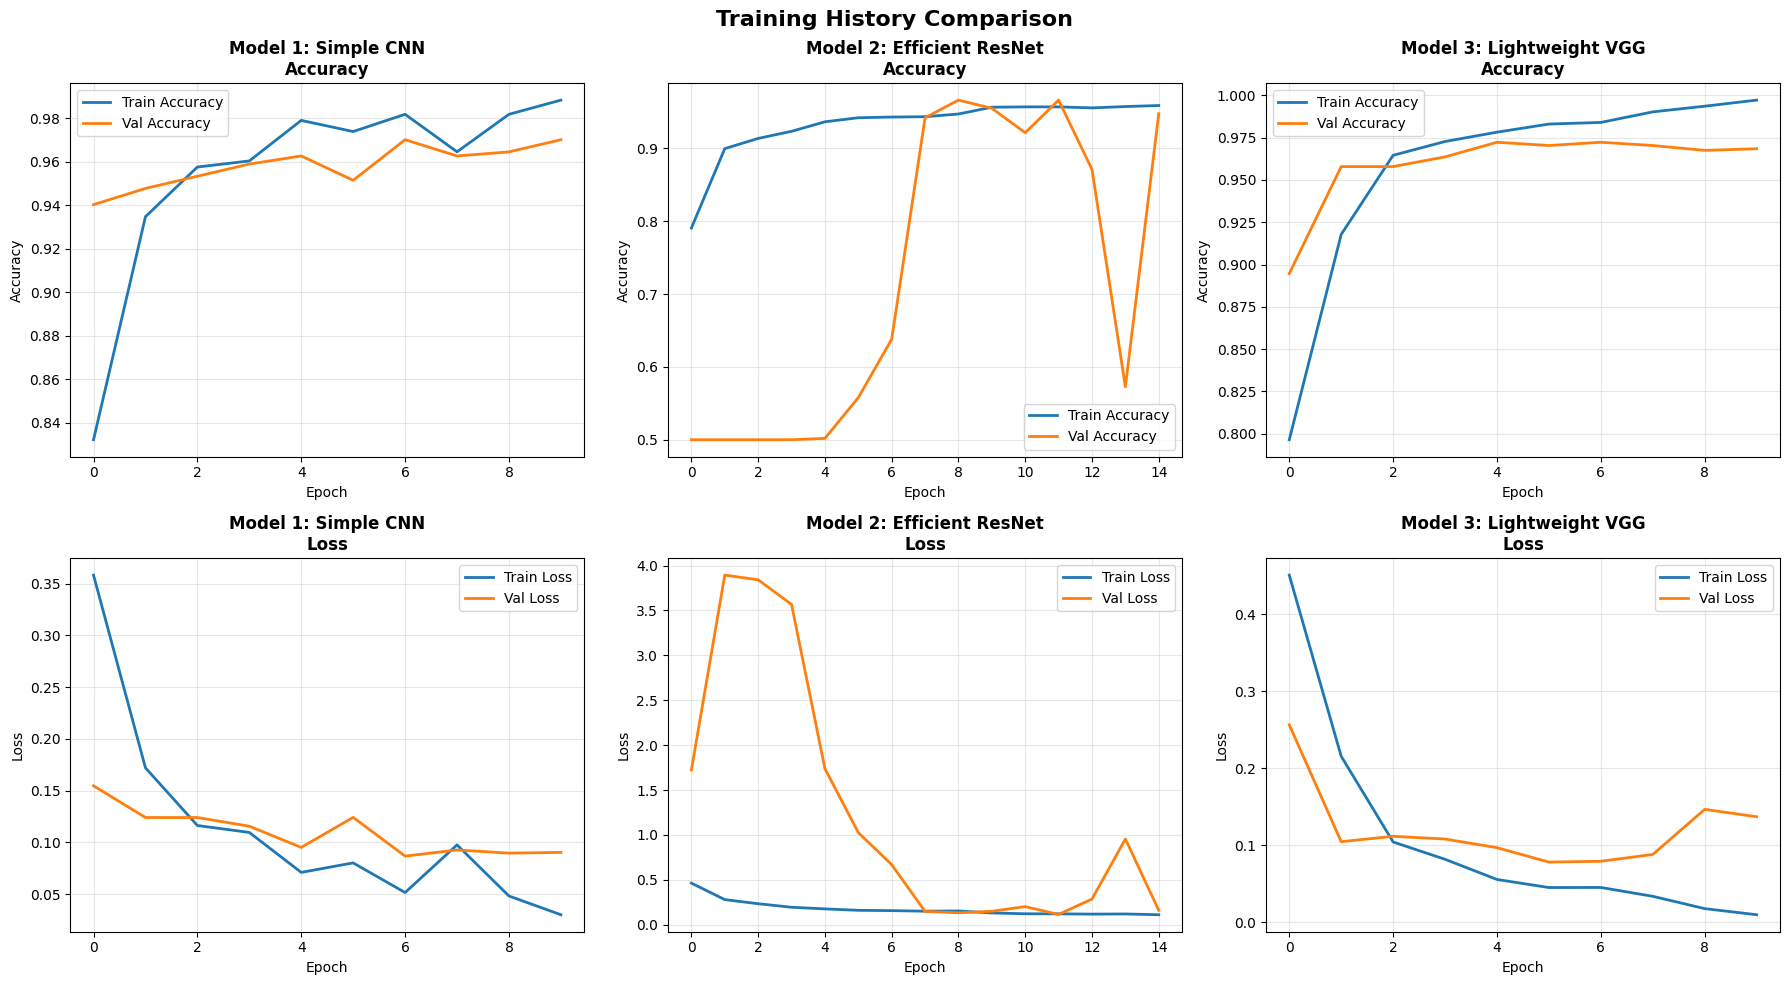

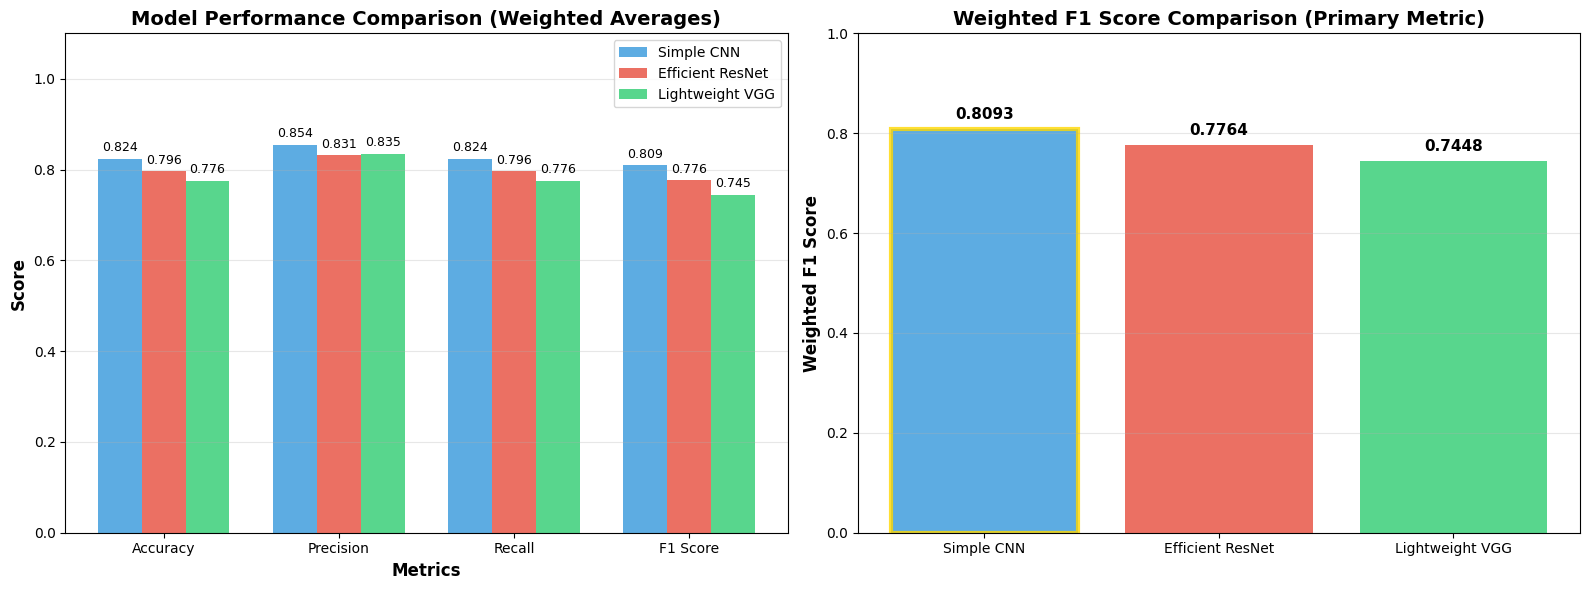

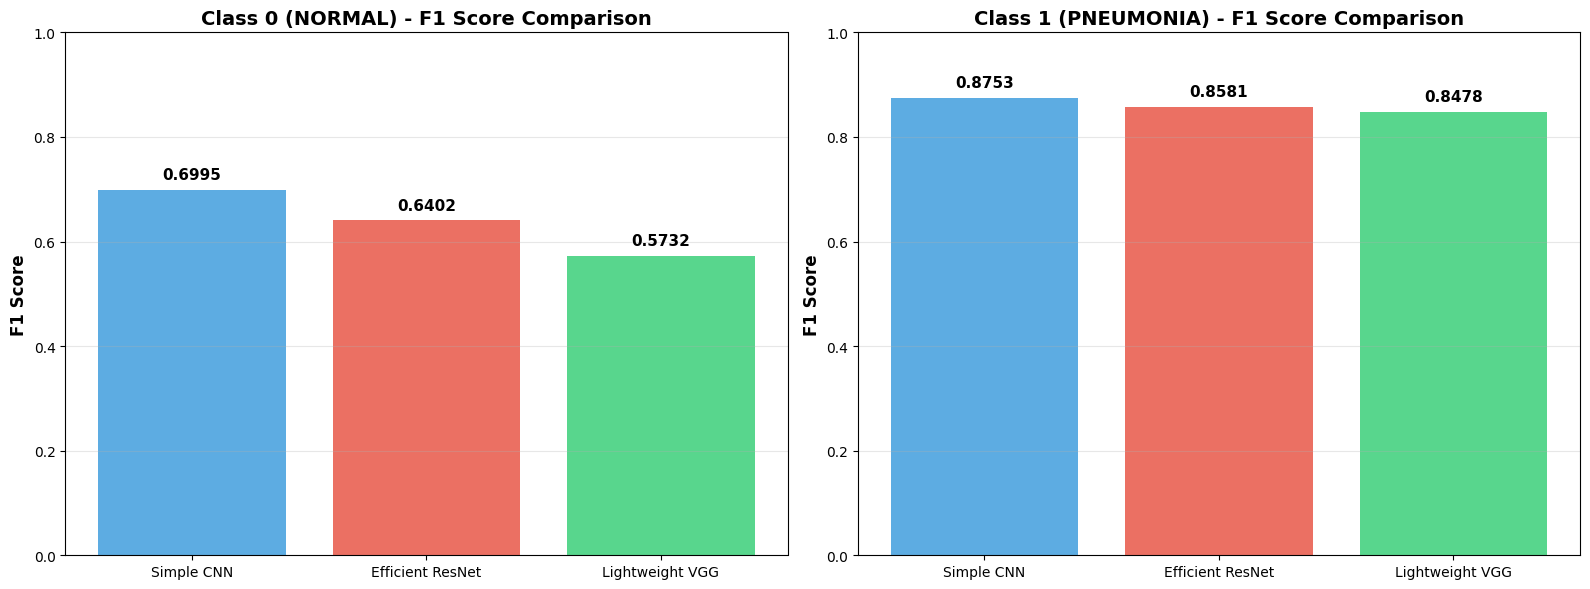

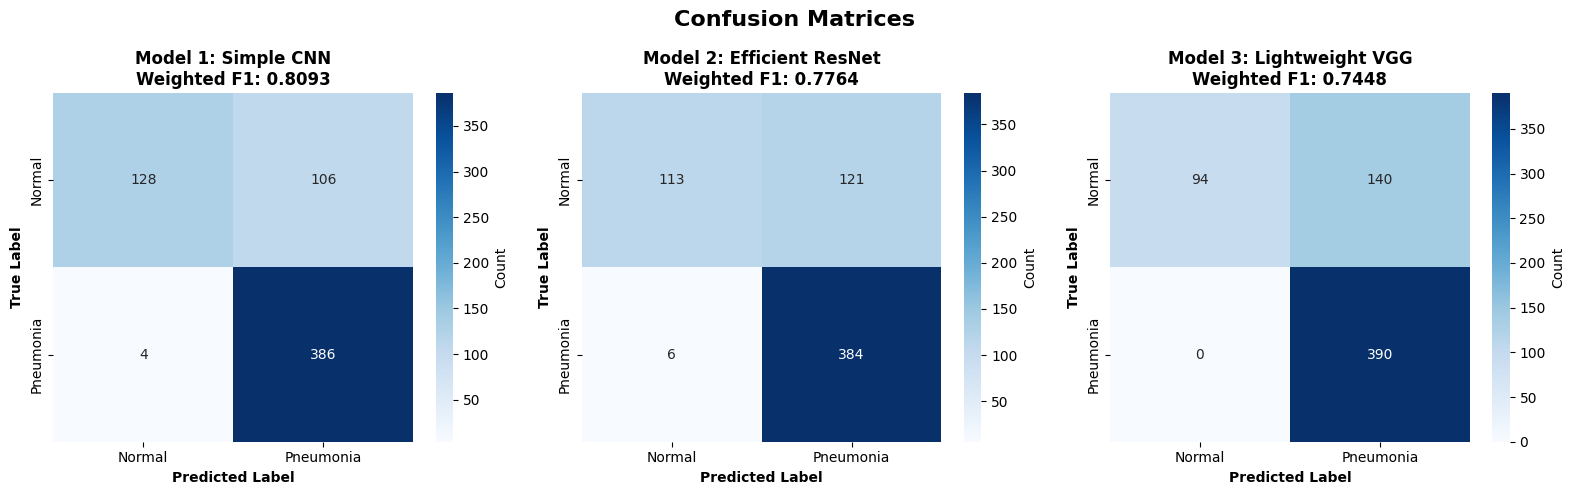

In [7]:
# ============================================
# MODEL COMPARISON
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ============================================
# STEP 1: CREATE COMPARISON DATAFRAME
# ============================================

print("\n" + "="*60)
print("CREATING MODEL COMPARISON DATAFRAME")
print("="*60)

# Create comparison dataframe with WEIGHTED AVERAGE metrics
comparison_data = {
    'Model': [
        'Model 1: Simple CNN',
        'Model 2: ResNet',
        'Model 3: VGG'
    ],
    'Accuracy': [accuracy_model1, accuracy_model2, accuracy_model3],
    'Precision (Weighted)': [precision_weighted_model1, precision_weighted_model2, precision_weighted_model3],
    'Recall (Weighted)': [recall_weighted_model1, recall_weighted_model2, recall_weighted_model3],
    'F1 Score (Weighted)': [f1_weighted_model1, f1_weighted_model2, f1_weighted_model3],
    'Training Time (s)': [model1_time, model2_time, model3_time]
}

comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("\n📊 Model Performance Comparison (Weighted Averages):")
print(comparison_df.to_string(index=False))

# Create detailed per-class comparison
print("\n📊 Detailed Per-Class Comparison:")
print("\n" + "="*60)

for model_num, model_name in enumerate(['Model 1: Simple CNN', 'Model 2: ResNet', 'Model 3: VGG'], 1):
    print(f"\n{model_name}:")
    if model_num == 1:
        print(f"  Class 0 (NORMAL):    Precision={precision_model1[0]:.4f}, Recall={recall_model1[0]:.4f}, F1={f1_model1[0]:.4f}")
        print(f"  Class 1 (PNEUMONIA): Precision={precision_model1[1]:.4f}, Recall={recall_model1[1]:.4f}, F1={f1_model1[1]:.4f}")
    elif model_num == 2:
        print(f"  Class 0 (NORMAL):    Precision={precision_model2[0]:.4f}, Recall={recall_model2[0]:.4f}, F1={f1_model2[0]:.4f}")
        print(f"  Class 1 (PNEUMONIA): Precision={precision_model2[1]:.4f}, Recall={recall_model2[1]:.4f}, F1={f1_model2[1]:.4f}")
    else:
        print(f"  Class 0 (NORMAL):    Precision={precision_model3[0]:.4f}, Recall={recall_model3[0]:.4f}, F1={f1_model3[0]:.4f}")
        print(f"  Class 1 (PNEUMONIA): Precision={precision_model3[1]:.4f}, Recall={recall_model3[1]:.4f}, F1={f1_model3[1]:.4f}")

# Find best model based on Weighted F1 Score
best_model_idx = comparison_df['F1 Score (Weighted)'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1 Score (Weighted)']

print("\n" + "="*60)
print(f"🏆 Best Model: {best_model_name} (Weighted F1: {best_f1:.4f})")
print("="*60)

# ============================================
# STEP 2: VISUALIZATIONS
# ============================================

# 1. Training History Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training History Comparison', fontsize=16, fontweight='bold')

models_history = [
    (history1, 'Model 1: Simple CNN'),
    (history2, 'Model 2: Efficient ResNet'),
    (history3, 'Model 3: Lightweight VGG')
]

for idx, (history, title) in enumerate(models_history):
    # Training & Validation Accuracy
    axes[0, idx].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, idx].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, idx].set_title(f'{title}\nAccuracy', fontweight='bold')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Accuracy')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)

    # Training & Validation Loss
    axes[1, idx].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1, idx].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1, idx].set_title(f'{title}\nLoss', fontweight='bold')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Loss')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Model Performance Comparison Bar Chart (Weighted Averages)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.25

model1_scores = [accuracy_model1, precision_weighted_model1, recall_weighted_model1, f1_weighted_model1]
model2_scores = [accuracy_model2, precision_weighted_model2, recall_weighted_model2, f1_weighted_model2]
model3_scores = [accuracy_model3, precision_weighted_model3, recall_weighted_model3, f1_weighted_model3]

bars1 = axes[0].bar(x - width, model1_scores, width, label='Simple CNN', alpha=0.8, color='#3498db')
bars2 = axes[0].bar(x, model2_scores, width, label='Efficient ResNet', alpha=0.8, color='#e74c3c')
bars3 = axes[0].bar(x + width, model3_scores, width, label='Lightweight VGG', alpha=0.8, color='#2ecc71')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

axes[0].set_xlabel('Metrics', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Score', fontweight='bold', fontsize=12)
axes[0].set_title('Model Performance Comparison (Weighted Averages)', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# Weighted F1 Score Comparison
f1_scores = [f1_weighted_model1, f1_weighted_model2, f1_weighted_model3]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = axes[1].bar(['Simple CNN', 'Efficient ResNet', 'Lightweight VGG'],
                   f1_scores, color=colors, alpha=0.8)
axes[1].set_ylabel('Weighted F1 Score', fontweight='bold', fontsize=12)
axes[1].set_title('Weighted F1 Score Comparison (Primary Metric)', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.0])

# Add value labels and highlight best
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)
    if i == best_model_idx:
        bars[i].set_linewidth(3)
        bars[i].set_edgecolor('gold')

plt.tight_layout()
plt.show()

# 3. Per-Class F1 Score Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Class 0 (NORMAL) F1 Scores
class0_f1 = [f1_model1[0], f1_model2[0], f1_model3[0]]
bars = axes[0].bar(['Simple CNN', 'Efficient ResNet', 'Lightweight VGG'],
                   class0_f1, color=colors, alpha=0.8)
axes[0].set_ylabel('F1 Score', fontweight='bold', fontsize=12)
axes[0].set_title('Class 0 (NORMAL) - F1 Score Comparison', fontweight='bold', fontsize=14)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

for i, v in enumerate(class0_f1):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)

# Class 1 (PNEUMONIA) F1 Scores
class1_f1 = [f1_model1[1], f1_model2[1], f1_model3[1]]
bars = axes[1].bar(['Simple CNN', 'Efficient ResNet', 'Lightweight VGG'],
                   class1_f1, color=colors, alpha=0.8)
axes[1].set_ylabel('F1 Score', fontweight='bold', fontsize=12)
axes[1].set_title('Class 1 (PNEUMONIA) - F1 Score Comparison', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.0])

for i, v in enumerate(class1_f1):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# 4. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

predictions = [
    (y_pred1, 'Model 1: Simple CNN', f1_weighted_model1),
    (y_pred2, 'Model 2: Efficient ResNet', f1_weighted_model2),
    (y_pred3, 'Model 3: Lightweight VGG', f1_weighted_model3)
]

for idx, (y_pred, title, f1) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'],
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{title}\nWeighted F1: {f1:.4f}', fontweight='bold')
    axes[idx].set_ylabel('True Label', fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.show()